In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import seaborn as sns
import math
sns.set()
import pystan
import arviz as az

seed = 1234

# Checks whether the model finds the correct parameters


## Create simulated infected data


### Manually defined values

In [2]:
D_e = 3 / 7
D_p = 2 / 7
D_i = 5 / 7

r = 0.4

r_a = 0.1 
r_p = 1.25 

In [3]:
# Total population, N.
N = 636500
# Initial number of infected and recovered individuals, I0 and R0.
E0, A0, P0, I0, R0 =  195, 130, 52, 195, 0 # Currently simulated with Vestland's data
# Everyone else, S0, is susceptible to infection initially.
S0 = N - E0 - A0 - P0 - I0 - R0

# Simulated traffic values
traffic = [-0.08, -0.14, -0.21, -0.27, -0.32, -0.26, -0.22, -0.15, -0.14]

# Correct values for simulated parameters
c_1 = 3.3
c_2 = 8.8

### Values which directly follow from previous definitions

In [4]:
n_days = len(traffic)
num_data_points = n_days

# A grid of time points (in days)
tc = np.linspace(1, n_days, n_days)

# 
betas = []
for i in range(n_days):
    betas.append(max(0,c_1 + c_2 * traffic[i]))

print(betas)

[2.5959999999999996, 2.0679999999999996, 1.4519999999999997, 0.9239999999999995, 0.48399999999999954, 1.0119999999999996, 1.3639999999999997, 1.9799999999999998, 2.0679999999999996]


### Run the SEAPIR-model to get a time series of the six states

In [5]:
# The SEAPIR model differential equations.
def deriv(y, t, N, betas):

    S, E, A, P, I, R = y
    
    i = 1
    while i < n_days and tc[i] < t:
        i = i + 1 
    
    i = min(i, n_days-1) # make sure the loop did not go too far
    
    beta = betas[i]
    
    dS_dt = - (r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N);
    dE_dt =  r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N - E/D_e;
    dA_dt =  r*E/D_e - A/D_i;
    dP_dt =  (1-r)*E/D_e - P/D_p;
    dI_dt =  P/D_p - I/D_i;
    dR_dt =  A/D_i + I/D_i;

    return dS_dt, dE_dt, dA_dt, dP_dt, dI_dt, dR_dt

# Initial conditions vector
# SEAPIR
y0 = S0, E0, A0, P0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, np.linspace(0, n_days, n_days+1), args=(N, betas))
S, E, A, P, I, R = ret.T
S, E, A, P, I, R = S[1:], E[1:], A[1:], P[1:], I[1:], R[1:]

### Plot the states E, A, P, I, R

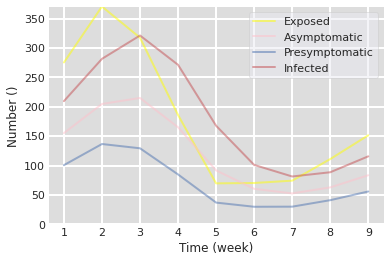

In [6]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#ax.plot(tc, S, 'black', alpha=0.5, lw=2, label='Susceptible')
ax.plot(tc, E, 'yellow', alpha=0.5, lw=2, label='Exposed')
ax.plot(tc, A, 'pink', alpha=0.5, lw=2, label='Asymptomatic')
ax.plot(tc, P, 'b', alpha=0.5, lw=2, label='Presymptomatic')
ax.plot(tc, I, 'r', alpha=0.5, lw=2, label='Infected')
#ax.plot(tc, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time (week)')
ax.set_ylabel('Number ()')
ax.set_ylim(0,int(max(max(E), max(A), max(P), max(I))))
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

### Get Poisson distributed daily infected data

In [7]:
lambda_poisson = []
for i in range(n_days):
    lambda_poisson.append(int(P[i] / D_p ))

lambda_poisson

[352, 478, 452, 296, 129, 104, 105, 143, 195]

In [8]:
# Poisson distribution OUTPUTS
infections_poisson = []

# For random jitter
mu = 0
sigma = 20

for i in range(n_days):
    infections_poisson.append(
        np.random.poisson(lam=lambda_poisson[i], size=1)[0] + 
        int(np.random.normal(mu, sigma, 1))
        )


infections_poisson 

[306, 436, 470, 266, 119, 68, 47, 137, 181]

## Run the model and get estimates for $c_1$ and $c_2$

In [9]:
sm = pystan.StanModel(file="./SEAPIR.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_feedd427e14d26e66c285aa2bd01233f NOW.


### Data

In [10]:
seapir_data = {
    "prior_means":[0,0],
    "prior_stds":[10,10],
    "n_training": num_data_points,
    "n_test": 0,
    "y0": y0,

    "t0": 0,
    "t_training": list(range(1, 1+num_data_points)),
    "t_test": np.empty(0),
    "N": N,

    "D_e": D_e,
    "D_p": D_p,
    "D_i": D_i,
    "r": r,
    "r_a": r_a,
    "r_p": r_p,

    "infections": infections_poisson,
    "infections_pred": np.empty(0).astype(int),
    "traffic": traffic,
    "traffic_pred": np.empty(0),
    
    # "traffic": np.empty((num_data_points, 0))
}
print(seapir_data)

{'prior_means': [0, 0], 'prior_stds': [10, 10], 'n_training': 9, 'n_test': 0, 'y0': (635928, 195, 130, 52, 195, 0), 't0': 0, 't_training': [1, 2, 3, 4, 5, 6, 7, 8, 9], 't_test': array([], dtype=float64), 'N': 636500, 'D_e': 0.42857142857142855, 'D_p': 0.2857142857142857, 'D_i': 0.7142857142857143, 'r': 0.4, 'r_a': 0.1, 'r_p': 1.25, 'infections': [306, 436, 470, 266, 119, 68, 47, 137, 181], 'infections_pred': array([], dtype=int64), 'traffic': [-0.08, -0.14, -0.21, -0.27, -0.32, -0.26, -0.22, -0.15, -0.14], 'traffic_pred': array([], dtype=float64)}


In [11]:
len(traffic)
num_data_points

9

### Fit the model

In [12]:
fit = sm.sampling(seapir_data, seed=seed)

In [13]:
print(fit)

Inference for Stan model: anon_model_feedd427e14d26e66c285aa2bd01233f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
constant            3.02    0.01   0.35   2.31   2.82   3.04   3.25   3.68   1005    1.0
traffic_slope        8.0    0.05   1.63   4.68   7.06   8.11   9.07  10.97    983    1.0
phi_inv             0.11  2.4e-3   0.07   0.03   0.06   0.09   0.14   0.31    946    1.0
phi                12.67     0.3   8.05   3.22    7.2  10.61  15.93  33.88    734    1.0
traffic_coeff[1]    3.02    0.01   0.35   2.31   2.82   3.04   3.25   3.68   1005    1.0
traffic_coeff[2]     8.0    0.05   1.63   4.68   7.06   8.11   9.07  10.97    983    1.0
y[1,1]             6.4e5    3.04  98.49  6.3e5  6.4e5  6.4e5  6.4e5  6.4e5   1049    1.0
y[2,1]             6.3e5    7.87 258.58  6.3e5  6.3e5  6.3e5  6.3e5  6.3e5   1081    1.0
y[3,1]    

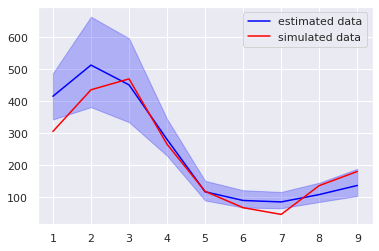

In [14]:
ret = np.empty((3, num_data_points))
ret[0, :] = np.quantile(fit['lambda_hat'], 0.5, axis=0)
ret[1, :] = np.quantile(fit['lambda_hat'], 0.05, axis=0)
ret[2, :] = np.quantile(fit['lambda_hat'], 0.95, axis=0)


p1 = plt.plot(seapir_data["t_training"], ret[0, :], label='estimated data', color='blue')
p2 = plt.plot(seapir_data["t_training"], infections_poisson, label='simulated data', color='red')

plt.fill_between(seapir_data["t_training"], ret[1, :], ret[2, :], color='blue', alpha=0.25)
plt.legend()
